In [1]:
import os
import sys
import glob
import pickle
from time import strftime, localtime

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_transform as tft

if '..' not in sys.path:
    sys.path.append('..')
from deep_utils import *

%matplotlib inline

First, let's fix the seed of the RNG, for reproducibility purposes

In [2]:
with open('/dev/random', 'rb') as fid:
    seed = int.from_bytes(fid.read(4), 'little')
tf.random.set_seed(seed)
print('Seed: {}'.format(seed))

Seed: 2169129819


#### Load the data

In [3]:
data_folder = '../data/IEEE14_D=2_DZA=60.0/'
var_names = ('omega_G1', 'Pe_G1')
n_vars = len(var_names)
inertia = {key: np.arange(2,11) + i/3 for i,key in enumerate(('training', 'test', 'validation'))}
time, x, y = load_data(data_folder, inertia, var_names)
x['train'] = x.pop('training')
y['train'] = y.pop('training')
N_vars, N_training_traces, N_samples = x['train'].shape

#### Normalize the data

In [4]:
x_train_mean = np.mean(x['train'], axis=(1,2))
x_train_std = np.std(x['train'], axis=(1,2))
for key in x:
    x[key] = tf.constant([(x[key][i].numpy() - m) / s for i,(m,s) in enumerate(zip(x_train_mean, x_train_std))])

Let's take a look at the data:

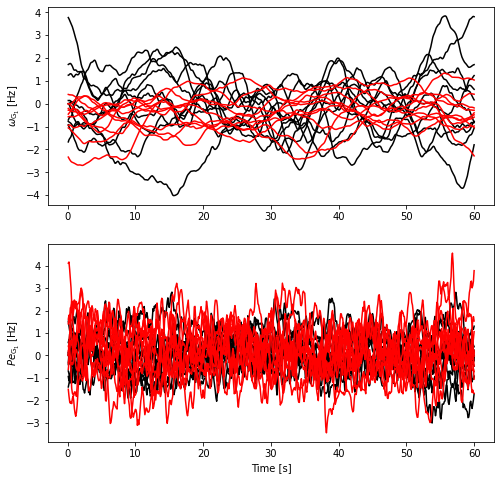

In [5]:
fig,ax = plt.subplots(2, 1, figsize=(8,8))
for i,a in enumerate(ax):
    a.plot(time, tf.transpose(x['train'][i, :10, :]), 'k')
    a.plot(time, tf.transpose(x['train'][i, -10:, :]), 'r')
ax[0].set_ylabel(r'$\omega_{\mathrm{G}_1}$ [Hz]')
ax[1].set_ylabel(r'$Pe_{\mathrm{G}_1}$ [Hz]')
ax[1].set_xlabel('Time [s]');

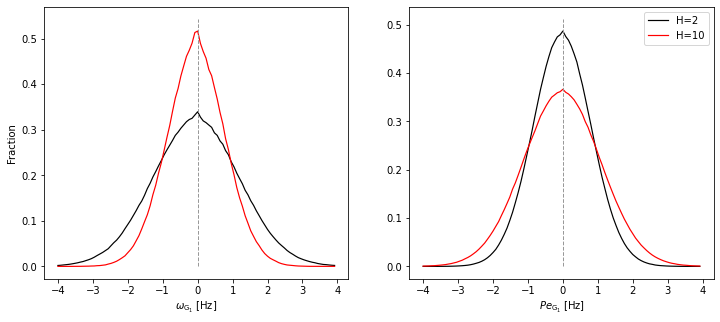

In [6]:
fig,ax = plt.subplots(1, 2, figsize=(12,5))
idx_2, _ = np.where(y['train'] == 2)
idx_10, _ = np.where(y['train'] == 10)

for i,a in enumerate(ax):
    n,edges = np.histogram(np.ndarray.flatten(x['train'][i,:,:].numpy()[idx_2,:]), \
                           bins=100, range=[-4,4], density=True)
    lim = n.max()
    a.plot(edges[:-1], n, 'k', linewidth=1.2, label='H=2')
    n,edges = np.histogram(np.ndarray.flatten(x['train'][i,:,:].numpy()[idx_10,:]), \
                           bins=100, range=[-4,4], density=True)
    lim = n.max() if n.max() > lim else lim
    a.plot(edges[:-1], n, 'r', linewidth=1.2, label='H=10')
    a.plot([0,0], [0, lim*1.05], '--', lw=1, color=[.6,.6,.6])
ax[0].set_xlabel(r'$\omega_{\mathrm{G}_1}$ [Hz]')
ax[1].set_xlabel(r'$Pe_{\mathrm{G}_1}$ [Hz]')
ax[0].set_ylabel('Fraction')
ax[1].legend(loc='upper right');

### Build the network
The basic network topology used here is taken from the following paper:

George, D., & Huerta, E. A. (2018). Deep neural networks to enable real-time multimessenger astrophysics. Physical Review D, 97(4), 044039. http://doi.org/10.1103/PhysRevD.97.044039

In [12]:
def make_preprocessing_pipeline_1D(N_samples, N_units, kernel_size, input_name):
    inp = keras.Input(shape=(N_samples, 1), name=input_name)
    for N_conv,N_pooling,sz in zip(N_units['conv'], N_units['pooling'], kernel_size):
        try:
            conv = layers.Conv1D(N_conv, sz, activation=None)(relu)
        except:
            conv = layers.Conv1D(N_conv, sz, activation=None)(inp)
        pool = layers.MaxPooling1D(N_pooling)(conv)
        relu = layers.ReLU()(pool)
    return inp,relu


def make_preprocessing_pipeline_2D(N_samples, N_units, kernel_size, input_name):
    inp = keras.Input(shape=(N_samples, 2, 1), name=input_name)
    for N_conv,N_pooling,sz in zip(N_units['conv'], N_units['pooling'], kernel_size):
        try:
            conv = layers.Conv2D(N_conv, [sz, 2], padding='same', activation=None)(relu)
        except:
            conv = layers.Conv2D(N_conv, [sz, 2], padding='same', activation=None)(inp)
        pool = layers.MaxPooling2D([N_pooling, 1])(conv)
        relu = layers.ReLU()(pool)
    return inp,relu

# how many dimensions the input data should have
N_dims = 2
# whether to have a deeper network (2) or not (1)
depth_level = 1
# a dropout coefficient of 0 means no Dropout layer
dropout_coeff = 0
# learning rate of the Adam optimizer
learning_rate = 1e-4

N_units = {}

if depth_level == 1:
    N_units['conv'] = [16, 32, 64]
    N_units['dense'] = [64]
elif depth_level == 2:
    N_units['conv'] = [64, 128, 256, 512]
    N_units['dense'] = [128, 64]

N_units['pooling'] = [4 for _ in range(len(N_units['conv']))]
kernel_size = [5 for _ in range(len(N_units['conv']))]

if N_dims == 1:
    inputs = []
    relus = []
    for var_name in var_names:
        inp,rel = make_preprocessing_pipeline_1D(N_samples, N_units, kernel_size, var_name)
        inputs.append(inp)
        relus.append(rel)
else:
    inputs,relu = make_preprocessing_pipeline_2D(N_samples, N_units, kernel_size, '_'.join(var_names))
    relus = [relu]

if len(relus) > 1:
    concat = layers.concatenate(relus)
    flatten = layers.Flatten()(concat)
else:
    flatten = layers.Flatten()(relus[0])

for i,n in enumerate(N_units['dense']):
    if i == 0:
        dense = layers.Dense(n, activation='relu')(flatten)
    else:
        dense = layers.Dense(n, activation='relu')(dense)

if dropout_coeff > 0:
    drop = layers.Dropout(dropout_coeff)(dense)
    output_tensor = layers.Dense(y['train'].shape[1])(drop)
else:
    output_tensor = layers.Dense(y['train'].shape[1])(dense)

model = tf.keras.Model(inputs=inputs, outputs=output_tensor)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.MeanAbsoluteError()

model.compile(optimizer=optimizer, loss=loss)

model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
omega_G1_Pe_G1 (InputLayer)  [(None, 600, 2, 1)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 600, 2, 16)        176       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 150, 2, 16)        0         
_________________________________________________________________
re_lu_9 (ReLU)               (None, 150, 2, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 150, 2, 32)        5152      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 2, 32)         0         
_________________________________________________________________
re_lu_10 (ReLU)              (None, 37, 2, 32)        

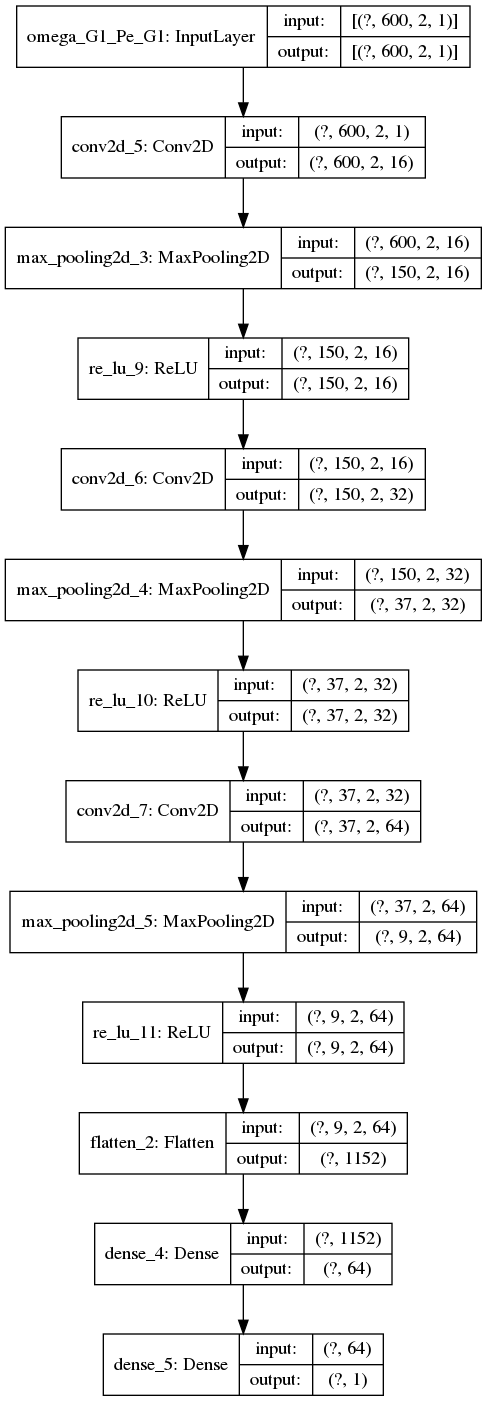

In [13]:
ts = strftime('%Y%m%d-%H%M%S', localtime())
path = 'experiments/' + ts
checkpoint_path = path + '/checkpoints'
os.makedirs(checkpoint_path)
keras.utils.plot_model(model, show_shapes=True, dpi=96)

#### Train the network

In [14]:
if N_dims == 2:
    for key in x:
        x[key] = tf.transpose(x[key], perm=(1,2,0))

# Create a callback that saves the model's weights
cp_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path + \
                                                 '/weights.{epoch:02d}-{val_loss:.2f}.h5',
                                                 save_weights_only=False,
                                                 save_best_only=True,
                                                 monitor='val_loss',
                                                 verbose=0)

N_epochs = 5
batch_size = 128
N_batches = np.ceil(N_training_traces / batch_size)
steps_per_epoch = np.max([N_batches, 100])

if N_dims == 1:
    x_train = {name: x['train'][i] for i,name in enumerate(var_names)}
    x_validation = {name: x['validation'][i] for i,name in enumerate(var_names)}
else:
    x_train = x['train']
    x_validation = x['validation']

# history = model.fit(x_train,
#                     y['train'],
#                     epochs = N_epochs,
#                     batch_size = batch_size,
#                     steps_per_epoch = steps_per_epoch,
#                     validation_data = (x_validation, y['validation']),
#                     verbose = 1,
#                     callbacks = [cp_callback])

In [15]:
x['train'].shape

TensorShape([135000, 600, 2])

#### Plot the loss as a function of the epoch number

In [ ]:
epochs = np.r_[0 : len(history.history['loss'])] + 1
plt.plot(epochs, history.history['loss'], 'k', label='Training')
plt.plot(epochs, history.history['val_loss'], 'r', label='Validation')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss');

#### Find the best model based on the validation loss

In [ ]:
checkpoint_files = glob.glob(checkpoint_path + '/*.h5')
val_loss = [float(file[:-3].split('-')[-1]) for file in checkpoint_files]
best_checkpoint = checkpoint_files[np.argmin(val_loss)]
best_model = tf.keras.models.load_model(best_checkpoint)

#### Compute the network prediction on the test set

In [ ]:
if N_dims == 1:
    y_prediction = np.squeeze(best_model.predict({name: x['test'][i] for i,name in enumerate(var_names)}))
else:
    y_prediction = np.squeeze(best_model.predict(x['test']))

#### Compute the Mean Absolute Percentage Error on the CNN prediction

In [ ]:
y_test = np.squeeze(y['test'].numpy())
mape_prediction = tf.keras.losses.mean_absolute_percentage_error(y_test, y_prediction).numpy()
print('MAPE on CNN prediction ... {:.2f}%'.format(mape_prediction))

#### Plot the results obtained with the CNN

In [ ]:
fig,ax = plt.subplots(1, 1, figsize=(7,7))
limits = np.squeeze(y['train'].numpy()[[0,-1]])
limits[1] += 1
ax.plot(limits, limits, 'g--')
ax.plot(y['test'], y_prediction, 'o', color=[1,.7,1], markersize=4, \
        markerfacecolor='w', markeredgewidth=1)
for i in range(int(limits[0]), int(limits[1])):
    idx,_ = np.where(np.abs(y['test'] - (i + 1/3)) < 1e-3)
    m = np.mean(y_prediction[idx])
    s = np.std(y_prediction[idx])
    ax.plot(i+1/3 + np.zeros(2), m + s * np.array([-1,1]), 'm-', linewidth=2)
    ax.plot(i+1/3, m, 'ms', markersize=8, markerfacecolor='w', \
            markeredgewidth=2)
ax.set_xlabel('Expected value')
ax.set_ylabel('Predicted value')
ax.axis([1.8, limits[1], 1.8, limits[1]])
fig.tight_layout()